In [2]:
# transformers, fastai 설치
!pip install fastai==2.2.5
!pip install transformers
!pip install transform

In [2]:
# 필요한 라이브러리 import 
from typing import Optional
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re

In [3]:
import torchvision
torchvision.__version__

'0.13.0'

In [4]:
# GPT2LMHeadMode
import torch
from transformers import GPT2LMHeadModel

In [5]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", bos_token='</s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>', mask_token='<mask>') 
tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


['▁안녕',
 '하',
 '세',
 '요.',
 '▁한국어',
 '▁G',
 'P',
 'T',
 '-2',
 '▁입',
 '니다.',
 '😤',
 ':)',
 'l^o']

In [6]:
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

## GPT2LMHeadModel 테스트

In [7]:
text = '파도에 서핑 보드에 남자'
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True)
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

파도에 서핑 보드에 남자친구를 태우고 바다에 빠졌다가 구조됐습니다.
이 남성은 지난달 31일 오후 7시쯤 전남 신안군 흑산면 가거도 남서쪽 약 4km 해상에서 여자 친구와 함께 낚시를 하던 중 갑자기 나타난 낚시꾼에 의해 발견돼 병원으로 옮겨졌지만 숨졌습니다.</d> 서울중앙지검 특수1부(부장검사 이원석)는 이날 오전 10시부터 김 전 차관을 피의자 신분으로 불러 조사하고 있다.
김씨는 검찰에서 "검찰 수사가 진행 중인 상황에서 (박근혜) 대통령이 최순실씨에게 뇌물을 준 사실이 없다"고 주장한 것으로 알려졌다.
앞서 박 대통령은 전날 대국민


## 크롤링한 데이터 txt파일로 불러오기

In [37]:
with open('tale.txt', encoding='UTF8') as f:
   lines = f.read()
lines=" ".join(lines.split())

#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 4,256 
dls = tls.dataloaders(bs=batch, seq_len=seq_len)

In [39]:
# 점유된 cuda 메모리 제거 (쿠다 오류)
import torch, gc
gc.collect()
torch.cuda.empty_cache()

## 데이터 학습

SuggestedLRs(valley=0.0012022644514217973)


epoch,train_loss,valid_loss,perplexity,time
0,3.207880,3.095649,22.101583,00:08


epoch,train_loss,valid_loss,perplexity,time
0,3.183040,3.095562,22.099644,00:08
1,3.176694,3.090276,21.983150,00:08
2,3.171780,3.083424,21.833038,00:08
3,3.158255,3.081958,21.801039,00:08
4,3.141709,3.080561,21.770605,00:08
5,3.131385,3.075413,21.658819,00:08
6,3.116824,3.073849,21.624971,00:08
7,3.108977,3.072694,21.600016,00:08
8,3.101571,3.066901,21.475252,00:08
9,3.097933,3.066866,21.474504,00:08


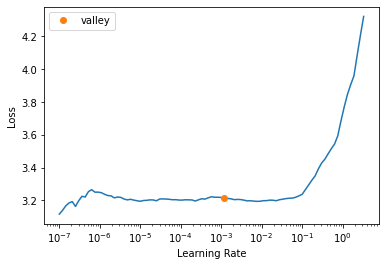

In [40]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(10)

## 학습된 모델 테스트

In [41]:
prompt="아이폰13프로맥스"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=50,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'아이폰13프로맥스 128GB 자급제 판매합니다 애플러스 케이스 새상품제품케어2 64gb 팝요 폰6기가 화이트 블랙 258급 배터리 성능 85 풀박드 실버 교환원'